In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


In [ ]:
adata = sc.read_h5ad("scanpy/iNeurons_onlyNeuronalCells.h5ad")
adata

AnnData object with n_obs × n_vars = 450359 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'plateID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'leiden_4', 'leiden_10', 'merged_clusters_from_10', 'parse_id', 'AP_axis', 'DV_axis', 'Basal_media', 'final_clustering', 'CycA', 'M_XAV', 'M_CHIR', 'M_RA', 'M_FGF8', 'M_BMP4', 'M_SHH', 'M_PM', 'tSNE_1', 'tSNE_2', 'umap_1', 'umap_2', 'Division', 'Neuron_type', 'Region', 'CellID', 'sample-CellID'

In [5]:
def cluster_avg(adata,clustering):
    cluster_avg_subset = pd.DataFrame(columns=adata.var_names, index=adata.obs[clustering].cat.categories)                                                                                                 
    for clust in adata.obs[clustering].cat.categories: 
        cluster_avg_subset.loc[clust] = adata[adata.obs[clustering].isin([clust]),:].X.mean(0)


    cluster_avg_subset = cluster_avg_subset.astype('float')
    cluster_avg_subset = cluster_avg_subset.T
    return(cluster_avg_subset)


In [ ]:
meta_all = adata.obs.copy()
meta_all['M_CycA'] = meta_all['CycA']
meta_all['sample_clean'] = [re.sub("_p(1|2)","",x) for x in meta_all['sample']]
meta_all.columns

Index(['sample', 'species', 'gene_count', 'tscp_count', 'mread_count',
       'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind',
       'plateID', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier',
       'doublet_score', 'predicted_doublet', 'leiden_4', 'leiden_10',
       'merged_clusters_from_10', 'parse_id', 'AP_axis', 'DV_axis',
       'Basal_media', 'final_clustering', 'CycA', 'M_XAV', 'M_CHIR', 'M_RA',
       'M_FGF8', 'M_BMP4', 'M_SHH', 'M_PM', 'tSNE_1', 'tSNE_2', 'umap_1',
       'umap_2', 'Division', 'Neuron_type', 'Region', 'CellID',
       'sample-CellID', 'M_CycA'],
      dtype='object')

In [8]:
meta_all['Basal_media'].value_counts()

Basal_media
mTeSR            264402
N2B27_2Si         91272
NIM               56018
N2B27_SB_CHIR     38667
Name: count, dtype: int64

In [10]:
meta_all['sample'].value_counts()

sample
iGlut_post_p1    100978
iGlut_pre         95735
iGABA_pre         90222
iGABA_post        82577
iGlut_post_p2     80847
Name: count, dtype: int64

In [12]:
meta_all['sample_clean'].value_counts()

sample_clean
iGlut_post    181825
iGlut_pre      95735
iGABA_pre      90222
iGABA_post     82577
Name: count, dtype: int64

In [ ]:
meta_all['condition'] = meta_all['sample_clean'].astype('str')+':'+meta_all['AP_axis'].astype('str')+'_'+meta_all['DV_axis'].astype('str')+"_"+meta_all['Basal_media'].astype('str')
meta_all['final_clustering_sample'] = meta_all['sample_clean'].astype('str')+"_"+meta_all['final_clustering'].astype('str')

In [15]:
for media in list(set(meta_all['Basal_media'])):
    meta_all[media] = 0
    meta_all.loc[meta_all['Basal_media']==media,media] = 1

In [16]:
meta_all['NGN2'] = 0
meta_all['ASCL1'] = 1
meta_all['timing'] = 1

for sample in list(set(meta_all['sample'])):
    if 'iGlut' in sample:
        meta_all.loc[meta_all['sample']==sample,'NGN2'] = 1
        meta_all.loc[meta_all['sample']==sample,'ASCL1'] = 0
    
    if 'pre' in sample:
        meta_all.loc[meta_all['sample']==sample,'timing'] = -1

    meta_all[sample] = 0
    meta_all.loc[meta_all['sample']==sample,sample] = 1

In [17]:
meta_condition = meta_all.groupby('condition').head(n=1).copy()
meta_condition.index = meta_condition['condition']

In [18]:
condition_sizes = meta_all.groupby('condition').size()
meta_condition.loc[condition_sizes.index,'ncells'] = condition_sizes

In [19]:
condition_tscpcounts = meta_all.groupby('condition')['n_counts'].mean()
meta_condition.loc[condition_tscpcounts.index,'ncounts'] = condition_tscpcounts

In [20]:
meta_all.columns

Index(['sample', 'species', 'gene_count', 'tscp_count', 'mread_count',
       'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind',
       'plateID', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier',
       'doublet_score', 'predicted_doublet', 'leiden_4', 'leiden_10',
       'merged_clusters_from_10', 'parse_id', 'AP_axis', 'DV_axis',
       'Basal_media', 'final_clustering', 'CycA', 'M_XAV', 'M_CHIR', 'M_RA',
       'M_FGF8', 'M_BMP4', 'M_SHH', 'M_PM', 'tSNE_1', 'tSNE_2', 'umap_1',
       'umap_2', 'Division', 'Neuron_type', 'Region', 'CellID',
       'sample-CellID', 'M_CycA', 'sample_clean', 'condition',
       'final_clustering_sample', 'mTeSR', 'N2B27_SB_CHIR', 'NIM', 'N2B27_2Si',


In [21]:
adata.obs = meta_all.loc[adata.obs.index]

In [22]:
variables = ['M_XAV', 'M_CHIR', 'M_RA', 'M_FGF8', 'M_BMP4', 'M_SHH', 'M_CycA','N2B27_SB_CHIR', 'mTeSR', 'NIM', 'N2B27_2Si','NGN2', 'ASCL1', 'timing']

In [23]:
adata.obs['condition'] = adata.obs['condition'].astype('category')

adata.obs['final_clustering_sample'] = adata.obs['final_clustering_sample'].astype('category')

In [24]:
expr_cond = cluster_avg(adata,"condition")
expr_cond_CPT = expr_cond/expr_cond.sum()*1e4
expr_cond_logCPT = np.log1p(expr_cond_CPT)

In [25]:
expr_cond_logCPT.loc['SLC18A3'].sort_values()

iGlut_pre:ctrl_ctrl_NIM              0.000000
iGABA_pre:CHIR_2_FGF8_SHH_2_NIM      0.000000
iGABA_pre:CHIR_2_FGF8_CycA_NIM       0.000000
iGABA_pre:ctrl_SHH_4_NIM             0.000000
iGABA_pre:CHIR_2_FGF8_BMP4_3_NIM     0.000000
                                       ...   
iGlut_post:RA_3_CHIR_ctrl_mTeSR      0.084688
iGlut_post:CHIR_4_SHH_4_mTeSR        0.085099
iGABA_post:CHIR_4_SHH_3_mTeSR        0.093556
iGlut_post:RA_4_CHIR_BMP4_2_mTeSR    0.095490
iGlut_post:RA_4_CHIR_SHH_3_mTeSR     0.100973
Name: SLC18A3, Length: 476, dtype: float64

In [26]:
expr_cond_logCPT.loc['NPY'].sort_values()

iGlut_post:FGF8_2_BMP4_2_mTeSR        0.000000
iGlut_post:CHIR_4_BMP4_1_mTeSR        0.000000
iGlut_post:CHIR_3_ctrl_mTeSR          0.000000
iGlut_post:CHIR_3_SHH_4_mTeSR         0.000000
iGlut_post:RA_3_SHH_4_mTeSR           0.000000
                                        ...   
iGABA_pre:RA_2_SHH_4_N2B27_SB_CHIR    0.609795
iGABA_post:RA_2_CHIR_ctrl_mTeSR       0.686252
iGABA_post:RA_2_CHIR_BMP4_1_mTeSR     0.848322
iGABA_post:RA_2_CHIR_BMP4_2_mTeSR     0.880346
iGABA_post:RA_2_CHIR_SHH_1_mTeSR      0.913195
Name: NPY, Length: 476, dtype: float64

In [27]:
print(list(meta_condition.columns))

['sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'plateID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'leiden_4', 'leiden_10', 'merged_clusters_from_10', 'parse_id', 'AP_axis', 'DV_axis', 'Basal_media', 'final_clustering', 'CycA', 'M_XAV', 'M_CHIR', 'M_RA', 'M_FGF8', 'M_BMP4', 'M_SHH', 'M_PM', 'tSNE_1', 'tSNE_2', 'umap_1', 'umap_2', 'Division', 'Neuron_type', 'Region', 'CellID', 'sample-CellID', 'M_CycA', 'sample_clean', 'condition', 'final_clustering_sample', 'mTeSR', 'N2B27_SB_CHIR', 'NIM', 'N2B27_2Si', 'NGN2', 'ASCL1', 'timing', 'iGABA_pre', 'iGlut_post_p1', 'iGlut_post_p2', 'iGlut_pre', 'iGABA_pos

In [28]:
expr_clusters = cluster_avg(adata,"final_clustering_sample")
expr_clusters_CPT = expr_clusters/expr_clusters.sum()*1e4
expr_clusters_logCPT = np.log1p(expr_clusters_CPT)

In [29]:
expr_clusters_logCPT.to_csv("combined_analysis/clustering_all_cells_logCPT_neur.tsv",sep="\t")

In [30]:
meta_tmp = adata.obs

In [31]:
meta_tmp.to_csv("combined_analysis/clustering_all_cells_meta_neur.tsv",sep="\t")

In [32]:
import pandas as pd
sheet_id = "1_0xptIY9_aZiVQ691iiZ_9lrqRx6SKchS5WEEFF4p20"
sheet_name = "NT_REC"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

gene_list = pd.read_csv(url)
gene_list_use = gene_list.loc[gene_list['Involvement'].isin(['Synthesis','Reuptake','Packaging/Release'])]
NT_genes = list(set(gene_list_use['Gene Symbol']))

import pandas as pd
sheet_id = "1_0xptIY9_aZiVQ691iiZ_9lrqRx6SKchS5WEEFF4p20"
sheet_name = "NP_3"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

gene_list_NP = pd.read_csv(url)
NP_genes = list(gene_list_NP['Approved symbol'])

NP_detected = {'iGlut_post':['CHGA','IGF2','NMU','PYY','SST'],
               'iGlut_pre':['ADCYAP1','IGF2','NMU','NTS','SST','TRH'],
               'iGABA_post':['CHGA','NMU','NPY','NTS'],
               'iGABA_pre':['ADM','CALCB','CHGA','IGF2','NMU','NPPB','NPY','PTHLH']}

#NP_genes = ['CHGA', 'IGF2', 'NMU', 'PYY', 'SST','ADCYAP1', 'IGF2', 'NMU', 'NTS', 'SST', 'TRH','CHGA', 'NMU', 'NPY', 'NTS','ADM', 'CALCB', 'CHGA', 'IGF2', 'NMU', 'NPPB', 'NPY', 'PTHLH']
#NP_genes = list(set(NP_genes))



In [33]:
NP_genes = [x for x in NP_genes if x in expr_cond_logCPT.index]
NT_genes = [x for x in NT_genes if x in expr_cond_logCPT.index]

NT_NP_genes = NT_genes + NP_genes
NT_NP_genes_detected = []
NT_NP_gene_expr = []
import anndata
for gene in NT_NP_genes:
    # Extract the gene expression vector for the specified gene
    gene_expression = adata.obs_vector(gene)

    # Count the number of cells expressing the gene (non-zero expression)
    cells_expressing_gene = sum(gene_expression > 0)
    if cells_expressing_gene>100:
        NT_NP_genes_detected.append(gene)
    cluster_expr_max = np.max(expr_clusters_logCPT.loc[gene])
    NT_NP_gene_expr.append(dict(gene=gene,nexpr=cells_expressing_gene,cluster_expr_max=cluster_expr_max))
NT_NP_gene_expr = pd.DataFrame(NT_NP_gene_expr)

In [34]:
NT_NP_gene_expr.loc[NT_NP_gene_expr['gene']=='KNG1']

,gene,nexpr,cluster_expr_max
53,KNG1,143,0.022047


In [35]:
NT_NP_gene_expr_sel = NT_NP_gene_expr.loc[NT_NP_gene_expr['nexpr']>100]
NT_NP_gene_expr_sel = NT_NP_gene_expr_sel.loc[NT_NP_gene_expr_sel['cluster_expr_max']>0.1]

In [36]:
NT_NP_genes_detected = list(set(NT_NP_gene_expr_sel['gene']))

In [37]:
NT_genes = [x for x in NT_genes if x in NT_NP_genes_detected]
NP_genes = [x for x in NP_genes if x in NT_NP_genes_detected]
NT_NP_genes = NT_NP_genes_detected

In [38]:
len(NT_NP_genes)

36

In [42]:
variables = ['ncounts','ncells','M_XAV', 'M_CHIR', 'M_RA', 'M_FGF8', 'M_BMP4', 'M_SHH', 'M_CycA','N2B27_SB_CHIR', 'mTeSR', 'NIM', 'N2B27_2Si','NGN2', 'ASCL1', 'timing']

In [ ]:
regr_summary = pd.DataFrame(index=NT_NP_genes,columns=variables)
for gene in NT_NP_genes:
    # Import necessary libraries
    import numpy as np
    import statsmodels.api as sm

    X = meta_condition[variables].copy()
    X = (X-X.mean())/X.std()

    # Add a column of ones to represent the intercept
    X = sm.add_constant(X)
    X = X.dropna(axis=1)

    y = expr_cond_logCPT.loc[gene]
    y = y.loc[X.index]
    D = pd.merge(y,X,left_index=True,right_index=True)
    y = np.array(y)
    
    # Fit a multivariate multiple linear regression model
    model = sm.OLS(y, X)
    result = model.fit()

    params = result.params.copy()
    pvalues = result.pvalues.copy()
    signedpvalues = -np.log10(pvalues)*params
    if result.rsquared_adj>0.1:
        regr_summary.loc[gene] = signedpvalues

In [44]:
regr_summary = regr_summary.dropna(axis=0)
regr_summary = regr_summary.astype('float')

In [45]:
import seaborn as sns

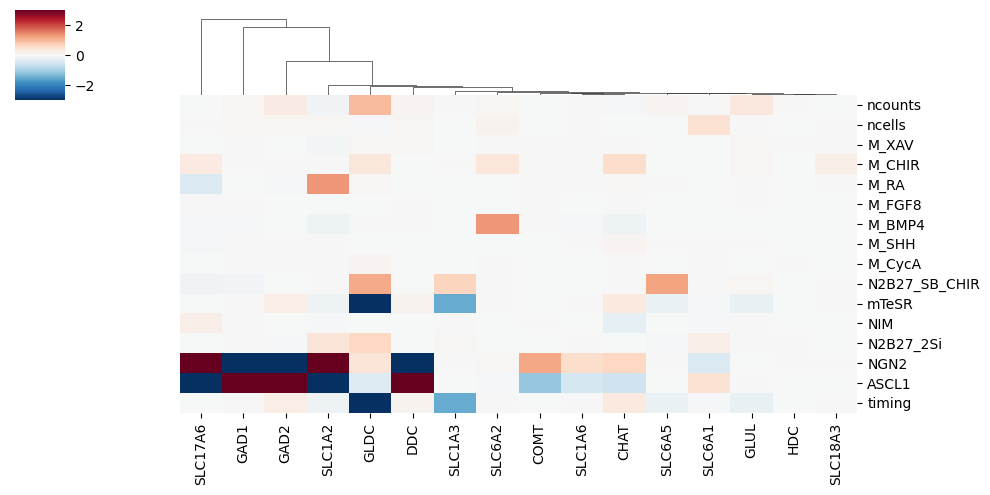

In [46]:
NT_genes_plot = [x for x in NT_genes if x in regr_summary.index]
sns.clustermap(regr_summary.loc[NT_genes_plot].T,vmax=3,vmin=-3,cmap='RdBu_r',figsize=(10,5),row_cluster=False)
plt.savefig("figures/NT_NP/linear_regression_NT_onlyneur.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

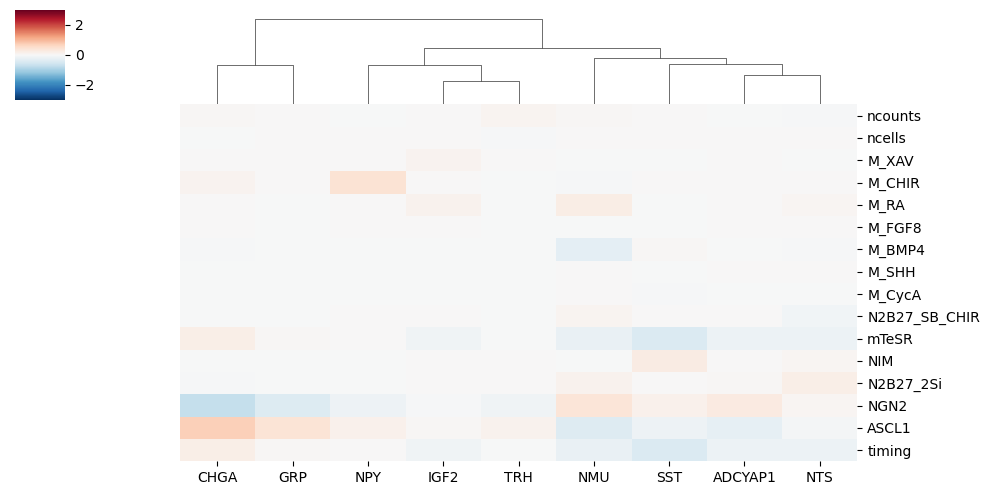

In [47]:
NP_genes_plot = [x for x in NP_genes if x in regr_summary.index]
sns.clustermap(regr_summary.loc[NP_genes_plot].T,vmax=3,vmin=-3,cmap='RdBu_r',figsize=(10,5),row_cluster=False)
plt.savefig("figures/NT_NP/linear_regression_NP_onlyneur.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

gene = 'SLC6A2'
y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)
y = np.array(y)

    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mae)
print("R-squared: ", r2)


Mean Squared Error:  0.02660358463555468
R-squared:  0.3001659633127739


In [49]:
lasso_coef = pd.DataFrame(model.coef_,index = X.columns)
lasso_coef.sort_values(by=0,ascending=False)

,0
M_BMP4,0.070528
M_CHIR,0.048091
ncells,0.031078
ncounts,0.021552
NGN2,0.014687
M_CycA,0.010815
timing,0.008951
mTeSR,0.008951
N2B27_SB_CHIR,0.004342
M_XAV,0.000513


In [50]:
model.coef_

array([ 0.        ,  0.02155238,  0.03107804,  0.00051286,  0.0480914 ,
       -0.00558372, -0.01196324,  0.07052832, -0.01012967,  0.01081472,
        0.00434237,  0.0089513 , -0.0054046 , -0.01058355,  0.01468745,
       -0.01468745,  0.0089513 ])

In [51]:
meta_condition

,sample,species,gene_count,tscp_count,mread_count,bc1_well,bc2_well,bc3_well,bc1_wind,bc2_wind,...,NGN2,ASCL1,timing,iGABA_pre,iGlut_post_p1,iGlut_post_p2,iGlut_pre,iGABA_post,ncells,ncounts
condition,,,,,,,,,,,,,,,,,,,,,
iGlut_post:XAV_3_BMP4_3_mTeSR,iGlut_post_p1,hg38,3542,9141,11365,A1,A1,A2,1,1,...,1,0,1,0,1,0,0,0,1264.0,5483.481013
iGlut_post:XAV_2_BMP4_3_mTeSR,iGlut_post_p1,hg38,1833,3562,4452,A2,A1,A12,2,1,...,1,0,1,0,1,0,0,0,1582.0,6081.526549
iGlut_post:XAV_1_BMP4_3_mTeSR,iGlut_post_p1,hg38,2632,6645,8238,A3,A1,B3,3,1,...,1,0,1,0,1,0,0,0,1414.0,5532.539604
iGlut_post:ctrl_BMP4_3_mTeSR,iGlut_post_p1,hg38,3096,7881,9902,A4,A1,B7,4,1,...,1,0,1,0,1,0,0,0,1287.0,4532.057498
iGlut_post:CHIR_1_BMP4_3_mTeSR,iGlut_post_p1,hg38,2319,5365,6627,A5,A1,E2,5,1,...,1,0,1,0,1,0,0,0,1704.0,6692.157864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iGABA_post:FGF8_2_SHH_4_mTeSR,iGABA_post,hg38,2436,5323,6006,H8,A1,C5,92,1,...,0,1,1,0,0,0,0,1,758.0,5526.663588
iGABA_post:FGF8_4_SHH_4_mTeSR,iGABA_post,hg38,4974,17203,19504,H9,A1,C7,93,1,...,0,1,1,0,0,0,0,1,981.0,4328.550459
iGABA_post:RA_4_CHIR_SHH_4_mTeSR,iGABA_post,hg38,1694,3211,3677,H10,A1,A2,94,1,...,0,1,1,0,0,0,0,1,295.0,4395.810169


In [52]:
expr_cond_logCPT.loc[NT_NP_genes].T.max().sort_values(ascending=False)

GLS        2.707335
SLC1A3     2.034567
GAD1       1.831705
SLC1A1     1.696776
IGF2       1.696776
GLDC       1.658208
SLC1A2     1.632742
IAPP       1.510134
SLC6A5     1.367268
SLC17A6    1.254185
GAD2       1.229807
TYR        1.171914
DDC        1.171914
COMT       1.171914
SLC6A2     0.961913
NPY        0.913195
CHAT       0.896417
NTS        0.825850
SLC6A1     0.746397
PTHLH      0.746280
CHGA       0.702197
SST        0.669923
NMU        0.650635
GLUL       0.605493
CALCB      0.585944
ADCYAP1    0.455291
TRH        0.417624
SLC18A2    0.391721
PYY        0.388959
GRP        0.283516
SLC1A6     0.277902
SLC6A9     0.268699
ADM        0.268264
SLC18A3    0.100973
CRH        0.066822
HDC        0.024468
dtype: float64

In [53]:
RF_summary = pd.DataFrame(index=NT_NP_genes,columns=variables)
RF_summary = RF_summary.T

from sklearn.ensemble import RandomForestRegressor

for gene in NT_NP_genes:
    # Import necessary libraries
    import numpy as np
    import statsmodels.api as sm

    # Assuming you have 'X' as your gene expression matrix and 'y' as your morphogen concentration matrix
    # Each row in 'X' corresponds to a condition, and each row in 'y' corresponds to the concentrations of 6 morphogens
    X = meta_condition[variables].copy()
    X = (X-X.mean())/X.std()

    # Add a column of ones to the gene expression matrix to represent the intercept
    X = X.dropna(axis=1)

    y = expr_cond_logCPT.loc[gene]
    y = y.loc[X.index]
    D = pd.merge(y,X,left_index=True,right_index=True)
    y = np.array(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train your Random Forest model
    model = RandomForestRegressor(n_estimators=100,max_depth=3)
    model.fit(X, y)  # X represents your feature data, and y is the target variable


    # Make predictions on the test data
    y_pred = model.predict(X_test)


    # Get feature importances
    feature_importances = model.feature_importances_

    # Evaluate the model
    mae = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

#    print("Mean Squared Error: ", mae)
#    print("R-squared: ", r2)
    RF_coef = pd.DataFrame(feature_importances,index = X.columns,columns=[gene])
#    lasso_coef = lasso_coef*r2

    # Fit a multivariate multiple linear regression model to get pos/neg signs
    model = sm.OLS(y, X)
    result = model.fit()

    params = result.params.copy()
    params = pd.DataFrame(params)
    params.columns = RF_coef.columns
    
    #multiply with linear model coefficient to get directionality
    RF_coef = RF_coef*np.sign(params)
    
    if r2>0.1:
        RF_summary[gene] = RF_coef


In [54]:
RF_summary = RF_summary.dropna(axis=1)
RF_summary = RF_summary.T

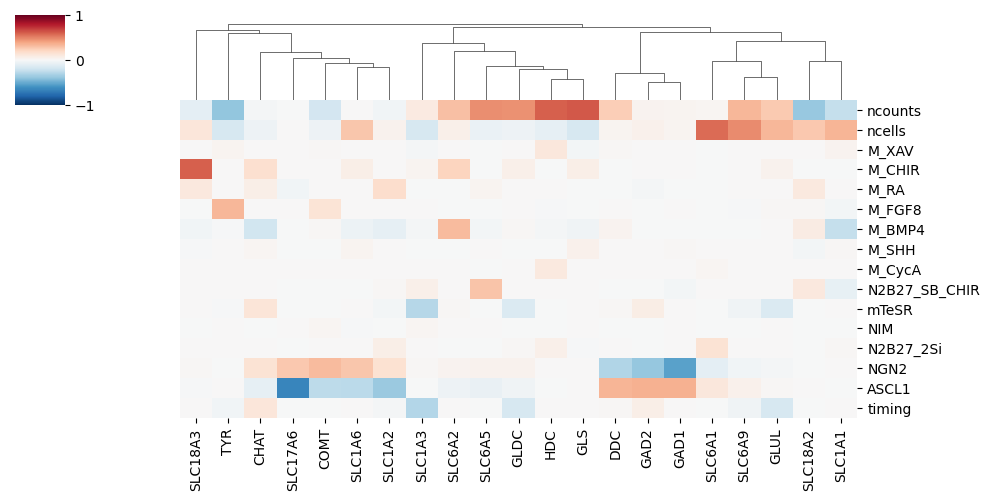

In [55]:
NT_genes_plot = [x for x in NT_genes if x in RF_summary.index]
sns.clustermap(RF_summary.loc[NT_genes_plot].T,vmax=1,vmin=-1,cmap='RdBu_r',figsize=(10,5),row_cluster=False)
plt.savefig("figures/NT_NP/RF_regression_NT_onlyneur_signed_withDopa.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

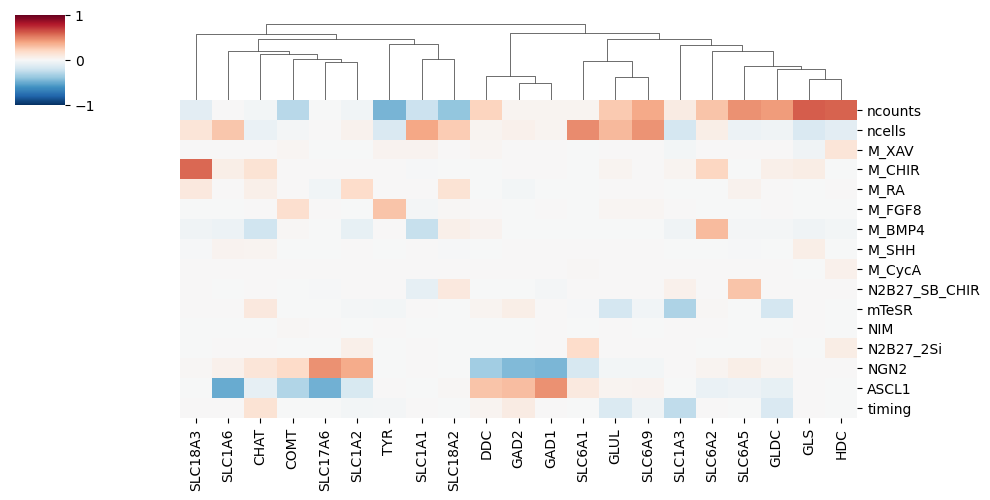

In [77]:
NT_genes_plot = [x for x in NT_genes if x in RF_summary.index]
sns.clustermap(RF_summary.loc[NT_genes_plot].T,vmax=1,vmin=-1,cmap='RdBu_r',figsize=(10,5),row_cluster=False)
plt.savefig("figures/NT_NP/RF_regression_NT_onlyneur_signed.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

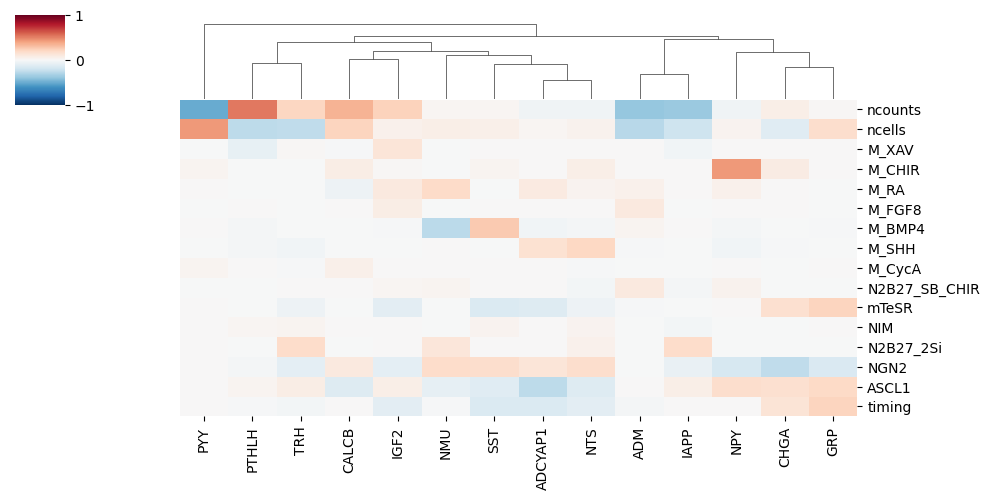

In [56]:
NP_genes_plot = [x for x in NP_genes if x in RF_summary.index]
sns.clustermap(RF_summary.loc[NP_genes_plot].T,vmax=1,vmin=-1,cmap='RdBu_r',figsize=(10,5),row_cluster=False)
plt.savefig("figures/NT_NP/RF_regression_NP_onlyneur_signed_withDopa.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

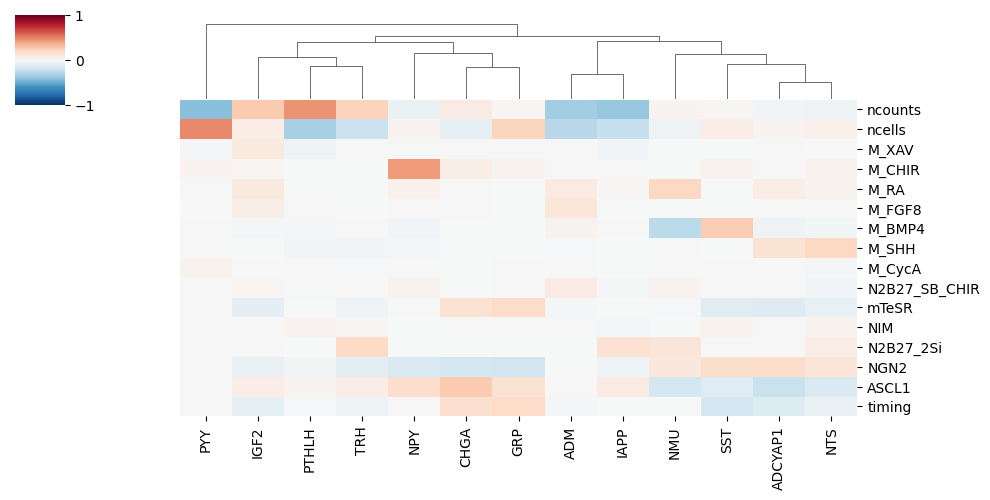

In [78]:
NP_genes_plot = [x for x in NP_genes if x in RF_summary.index]
sns.clustermap(RF_summary.loc[NP_genes_plot].T,vmax=1,vmin=-1,cmap='RdBu_r',figsize=(10,5),row_cluster=False)
plt.savefig("figures/NT_NP/RF_regression_NP_onlyneur_signed.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [57]:
selected_genes_NT = ['SLC18A3','SLC1A6','CHAT','COMT','SLC17A6','SLC1A2','TYR','SLC1A1','GAD1','SLC1A3','SLC6A2','DDC']
selected_genes_NP = ['TRH','NPY','CHGA','GRP','NMU','SST','ADCYAP1','NTS']
selected_genes_NTNP = selected_genes_NT + selected_genes_NP

In [58]:
import matplotlib as mpl

In [59]:
mpl.rcParams['pdf.fonttype'] = 42

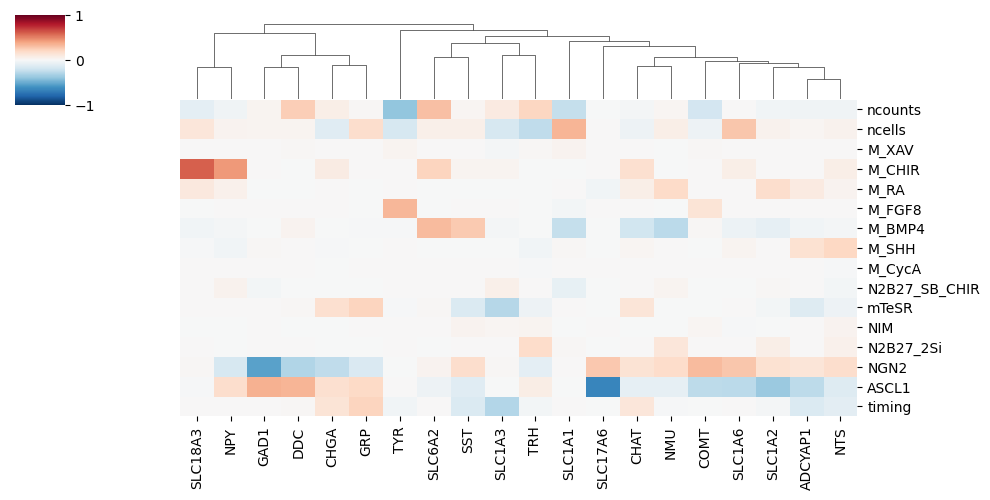

In [60]:
sns.clustermap(RF_summary.loc[selected_genes_NTNP].T,vmax=1,vmin=-1,cmap='RdBu_r',figsize=(10,5),row_cluster=False)
plt.savefig("figures/NT_NP/RF_regression_selNTNP_onlyneur_signed_withDopa.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("figures/NT_NP/RF_regression_selNTNP_onlyneur_signed_withDopa.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [109]:
D['TF_timing'] = 0
D.loc[D['NGN2']>0,'TF_timing'] = 2
D.loc[D['timing']<0,'TF_timing'] = D.loc[D['timing']<0,'TF_timing'] - 1

In [117]:
D['timing'].value_counts()

timing
 0.807098    288
-1.236405    188
Name: count, dtype: int64

In [121]:
D_pre = D.loc[D['timing']<0].copy()
D_post = D.loc[D['timing']>0].copy()

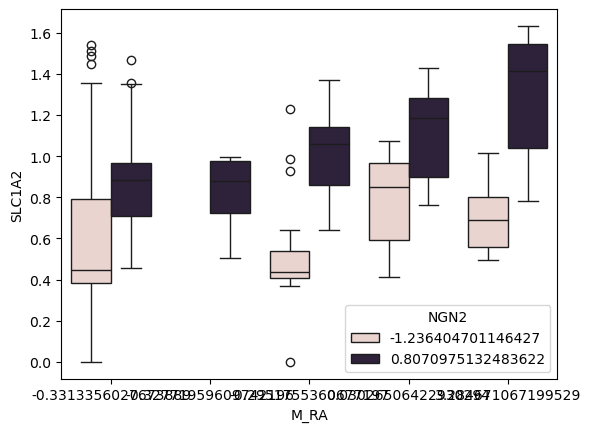

In [127]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'SLC1A2'

y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)

sns.boxplot(x='M_RA',y='SLC1A2',hue='NGN2',data=D)
plt.show()

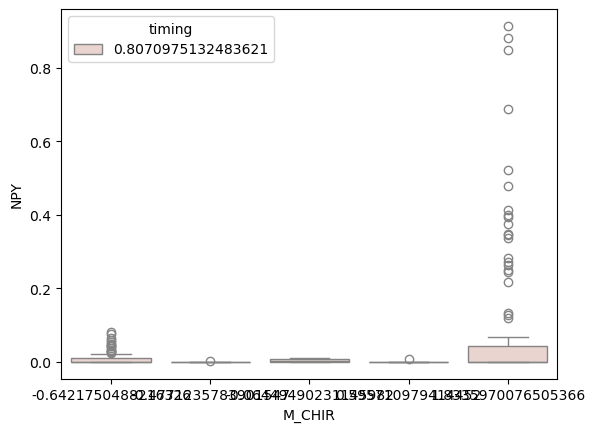

In [123]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'NPY'

y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)

sns.boxplot(x='M_CHIR',y='NPY',hue='timing',data=D_post)
plt.show()

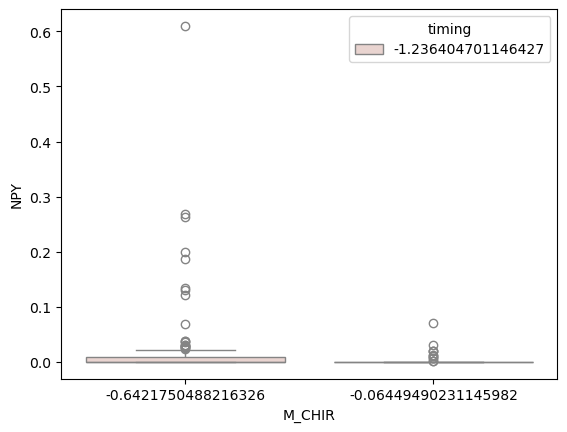

In [122]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'NPY'

y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)

sns.boxplot(x='M_CHIR',y='NPY',hue='timing',data=D_pre)
plt.show()

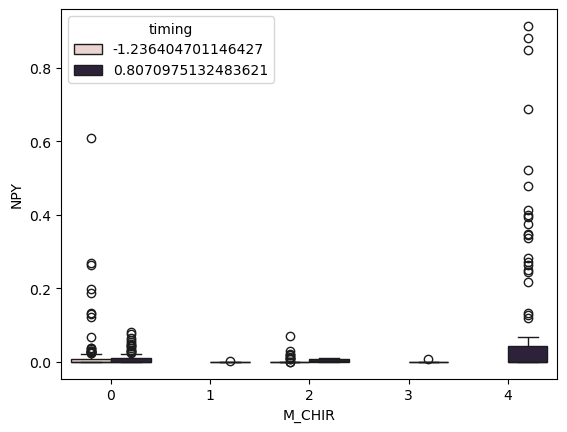

In [132]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'NPY'

y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)

sns.boxplot(x='M_CHIR',y='NPY',hue='timing',data=D)
plt.xticks([0,1,2,3,4],[0,1,2,3,4])
plt.show()

<Axes: xlabel='M_CHIR', ylabel='SLC18A3'>

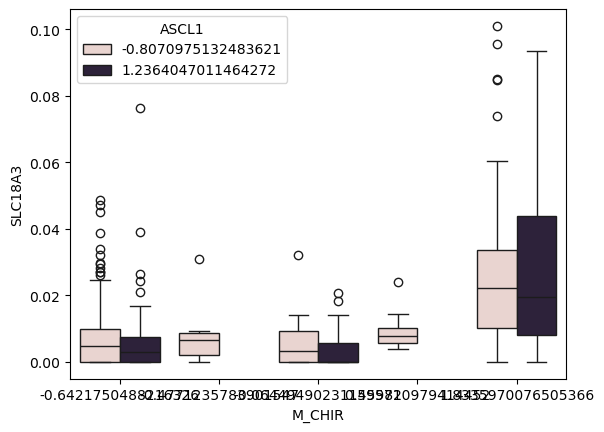

In [128]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'SLC18A3'

y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)

sns.boxplot(x='M_CHIR',y='SLC18A3',hue='ASCL1',data=D)

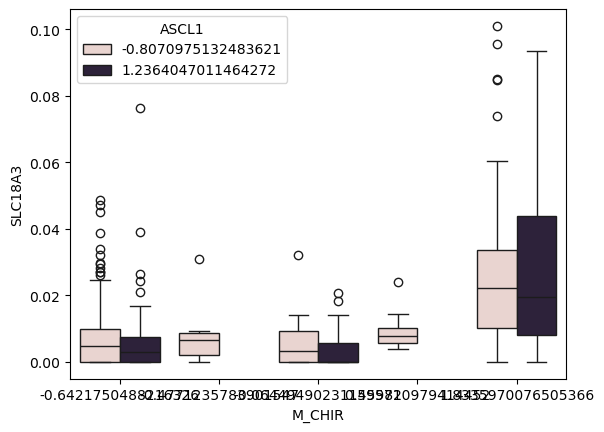

In [152]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'SLC18A3'

y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)

sns.boxplot(x='M_CHIR',y='SLC18A3',hue='ASCL1',data=D)
plt.show()

In [ ]:
color_dict['iGABA_post']='crimson'
color_dict['iGABA_pre']='lightpink'
color_dict['iGlut_post_p1']='royalblue'
color_dict['iGlut_post_p2']='royalblue'
color_dict['iGlut_pre']='deepskyblue'


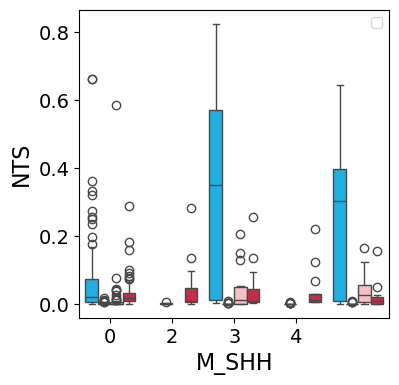

In [198]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'NTS'
morph = 'M_SHH'
y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)


D['TF'] = 'ASCL1'
D.loc[D['NGN2']>0,'TF'] = 'NGN2'
D['time'] = 'post'
D.loc[D['timing']<0,'time'] = 'pre'
D['TF_time'] = D['TF']+"_"+D['time']
#D = D.loc[D['M_RA']!=-0.32771959609742196]
#D = D.loc[D['M_CHIR']!= -0.4771235783901547]
#D = D.loc[D['M_CHIR']!=0.595710979414452]

plt.figure(figsize=(4,4))
sns.boxplot(x=morph,y=gene,hue='TF_time',data=D,
            hue_order=['NGN2_pre','NGN2_post','ASCL1_pre','ASCL1_post'],
            palette=['deepskyblue','royalblue','lightpink','crimson'])
plt.xticks([0,1,2,3],[0,2,3,4],fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(gene,fontsize=16)
plt.xlabel(morph,fontsize=16)
plt.legend([])
plt.savefig("figures/NT_NP/examples_"+gene+"_"+morph+".png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("figures/NT_NP/examples_"+gene+"_"+morph+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

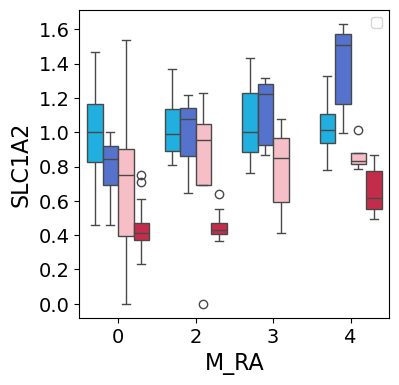

In [196]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'SLC1A2'
morph = 'M_RA'
y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)


D['TF'] = 'ASCL1'
D.loc[D['NGN2']>0,'TF'] = 'NGN2'
D['time'] = 'post'
D.loc[D['timing']<0,'time'] = 'pre'
D['TF_time'] = D['TF']+"_"+D['time']
D = D.loc[D['M_RA']!=-0.32771959609742196]
#D = D.loc[D['M_CHIR']!= -0.4771235783901547]
#D = D.loc[D['M_CHIR']!=0.595710979414452]

plt.figure(figsize=(4,4))
sns.boxplot(x=morph,y=gene,hue='TF_time',data=D,
            hue_order=['NGN2_pre','NGN2_post','ASCL1_pre','ASCL1_post'],
            palette=['deepskyblue','royalblue','lightpink','crimson'])
plt.xticks([0,1,2,3],[0,2,3,4],fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(gene,fontsize=16)
plt.xlabel(morph,fontsize=16)
plt.legend([])
plt.savefig("figures/NT_NP/examples_"+gene+"_"+morph+".png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("figures/NT_NP/examples_"+gene+"_"+morph+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [194]:
list(set(D['M_RA']))

[-0.3313356027673889,
 -0.32771959609742196,
 -0.2951755360677197,
 3.284671067199529,
 0.03026506422930294]

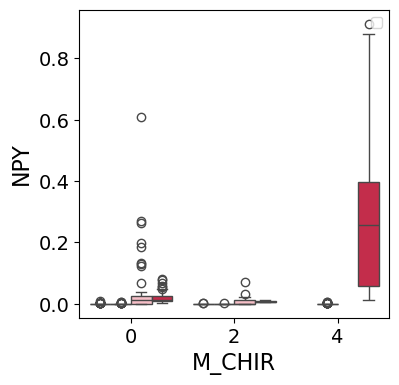

In [192]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'NPY'
morph = 'M_CHIR'
y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)


D['TF'] = 'ASCL1'
D.loc[D['NGN2']>0,'TF'] = 'NGN2'
D['time'] = 'post'
D.loc[D['timing']<0,'time'] = 'pre'
D['TF_time'] = D['TF']+"_"+D['time']
#D = D.loc[D['M_BMP4']!=0.3288419401485881]
D = D.loc[D['M_CHIR']!= -0.4771235783901547]
D = D.loc[D['M_CHIR']!=0.595710979414452]

plt.figure(figsize=(4,4))
sns.boxplot(x=morph,y=gene,hue='TF_time',data=D,
            hue_order=['NGN2_pre','NGN2_post','ASCL1_pre','ASCL1_post'],
            palette=['deepskyblue','royalblue','lightpink','crimson'])
plt.xticks([0,1,2],[0,2,4],fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(gene,fontsize=16)
plt.xlabel(morph,fontsize=16)
plt.legend([])
plt.savefig("figures/NT_NP/examples_"+gene+"_"+morph+".png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("figures/NT_NP/examples_"+gene+"_"+morph+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

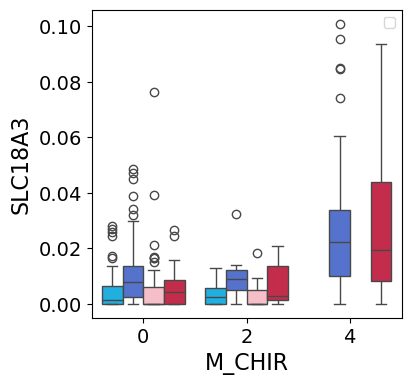

In [191]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'SLC18A3'
morph = 'M_CHIR'
y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)


D['TF'] = 'ASCL1'
D.loc[D['NGN2']>0,'TF'] = 'NGN2'
D['time'] = 'post'
D.loc[D['timing']<0,'time'] = 'pre'
D['TF_time'] = D['TF']+"_"+D['time']
#D = D.loc[D['M_BMP4']!=0.3288419401485881]
D = D.loc[D['M_CHIR']!= -0.4771235783901547]
D = D.loc[D['M_CHIR']!=0.595710979414452]

plt.figure(figsize=(4,4))
sns.boxplot(x=morph,y=gene,hue='TF_time',data=D,
            hue_order=['NGN2_pre','NGN2_post','ASCL1_pre','ASCL1_post'],
            palette=['deepskyblue','royalblue','lightpink','crimson'])
plt.xticks([0,1,2],[0,2,4],fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(gene,fontsize=16)
plt.xlabel(morph,fontsize=16)
plt.legend([])
plt.savefig("figures/NT_NP/examples_"+gene+"_"+morph+".png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("figures/NT_NP/examples_"+gene+"_"+morph+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

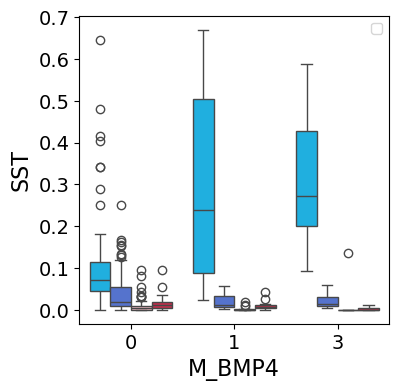

In [190]:
X = meta_condition[variables].copy()
X = (X-X.mean())/X.std()

# Add a column of ones to the gene expression matrix to represent the intercept
X = X.dropna(axis=1)

gene = 'SST'

y = expr_cond_logCPT.loc[gene]
y = y.loc[X.index]
D = pd.merge(y,X,left_index=True,right_index=True)


D['TF'] = 'ASCL1'
D.loc[D['NGN2']>0,'TF'] = 'NGN2'
D['time'] = 'post'
D.loc[D['timing']<0,'time'] = 'pre'
D['TF_time'] = D['TF']+"_"+D['time']
D = D.loc[D['M_BMP4']!=0.3288419401485881]

plt.figure(figsize=(4,4))
sns.boxplot(x='M_BMP4',y=gene,hue='TF_time',data=D,
            hue_order=['NGN2_pre','NGN2_post','ASCL1_pre','ASCL1_post'],
            palette=['deepskyblue','royalblue','lightpink','crimson'])
plt.xticks([0,1,2],[0,1,3],fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(gene,fontsize=16)
plt.xlabel('M_BMP4',fontsize=16)
plt.legend([])
plt.savefig("figures/NT_NP/examples_SST_BMP4.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("figures/NT_NP/examples_SST_BMP4.pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()